# Facial Keypoint Dectection

## Detect the location of keypoints on face images

Excerpt from https://www.kaggle.com/c/facial-keypoints-detection

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

tracking faces in images and video
analysing facial expressions
detecting dysmorphic facial signs for medical diagnosis
biometrics / face recognition
Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Understanding data
Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

In [3]:
# Separate X_train and y_train from the training data. 
# X_train will contain the images.
# y_train will contain labels for corresponding to the images.

# X_train[i] will contain a flattened 96x96 image as a numpy array.
# y_train[i] will contain 30 labels: 15 pairs of x,y coordinates for the features mentioned above.

import os.path

np_loaded_data_file = "../data/train_data.npz"
if not os.path.isfile(np_loaded_data_file):
    print "reading data ..."
    try:
        df=pd.read_csv('../data/training.csv', sep=',')
    except:
        print "Download training.csv from kaggle website"
    input_train = df.values
    
    X_train = input_train[:, 30]
    y_train = input_train[:, 0:30]
    
    templist = []
    for i in range(X_train.shape[0]):
        templist.append([int(s) for s in X_train[i].split()])
    X_train = np.array(templist)
    
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    np.savez(np_loaded_data_file, X_train=X_train, y_train=y_train)
else:
    print "training data %s exists. loading... " % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    X_train = npzfile['X_train']
    y_train = npzfile['y_train']


training data ../data/train_data.npz exists. loading... 


[[6240  358  719 4353]
 [1019 2776 1108 6370]
 [5162 1379 4149 4923]
 [2952 6753 1147 2443]]


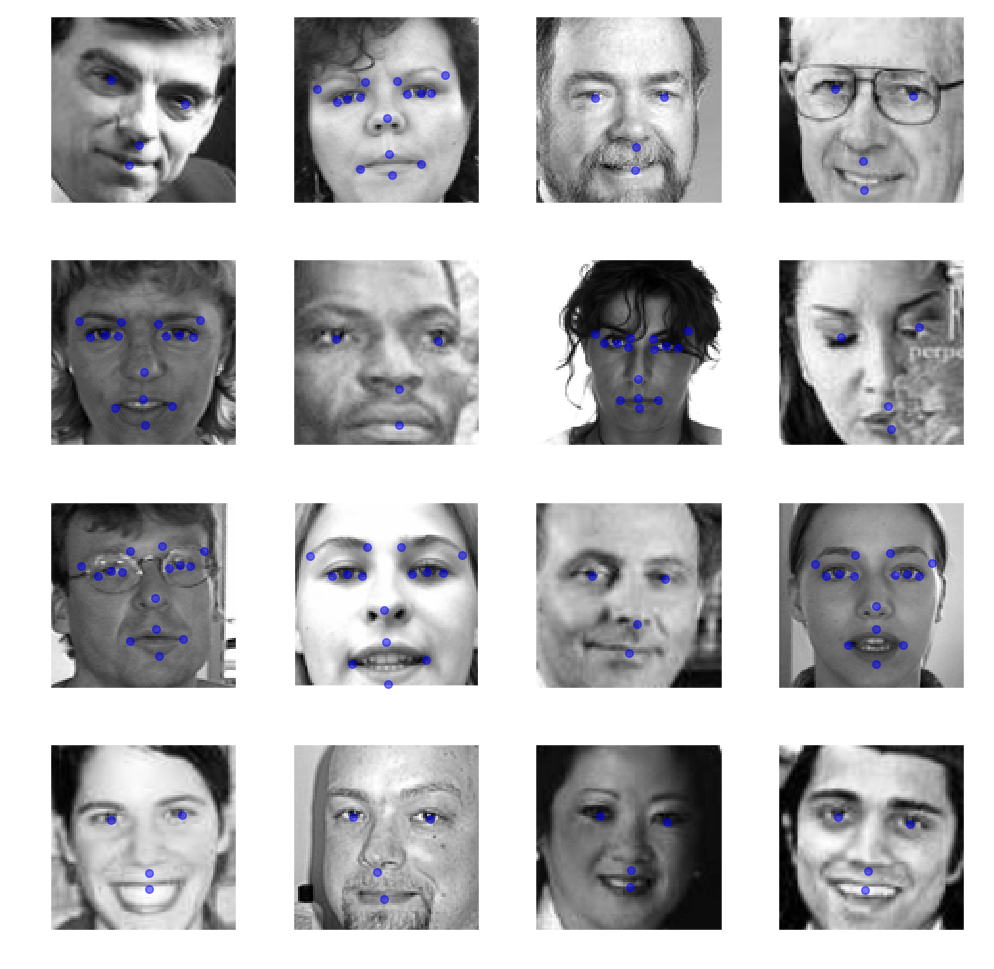

In [4]:
# print X_train.shape
# print y_train.shape

N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train[i].reshape(96, 96)
        b = y_train[i]
        b_x = b[0::2]
        b_y = b[1::2]

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.gca().axis('off')
plt.show()


In [5]:
# From the above pictures, we see that some of the features are missing.
print y_train[4096]

# The missing keypoints appear as nan in the coordinates.


[ 65.61309767  36.20282791  28.76248186  38.2312186           nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  45.32829767  68.32029767          nan          nan          nan
          nan          nan          nan  47.0187907   78.80070698]


In [6]:
# The following code counts the number of images with atleast one missing feature.
count = 0
for y in y_train:
    isnan = False
    for yy in y:
        if np.isnan(yy):
            isnan = True
            break
    if isnan:
        count += 1
print count



4909


In [7]:
# Next, we use the following piece of code to understand which features miss the most.

y_nan_check = np.isnan(y_train)

a = np.sum(y_nan_check, axis=1)
b = np.sum(y_nan_check, axis=0)

full_feature_check = (a == 0)
print "number of images with atleast one missing feature = ", np.sum(np.logical_not(full_feature_check))

feature_labels = "left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image"
feature_labels = feature_labels.split(",")

import pprint
print "Assuming _x and _y for a feature always go missing together, "

pprint.pprint(dict(zip(feature_labels[0::2] , b[0::2])))

number of images with atleast one missing feature =  4909
Assuming _x and _y for a feature always go missing together, 
{'left_eye_center_x': 10,
 'left_eye_inner_corner_x': 4778,
 'left_eye_outer_corner_x': 4782,
 'left_eyebrow_inner_end_x': 4779,
 'left_eyebrow_outer_end_x': 4824,
 'mouth_center_bottom_lip_x': 33,
 'mouth_center_top_lip_x': 4774,
 'mouth_left_corner_x': 4780,
 'mouth_right_corner_x': 4779,
 'nose_tip_x': 0,
 'right_eye_center_x': 13,
 'right_eye_inner_corner_x': 4781,
 'right_eye_outer_corner_x': 4781,
 'right_eyebrow_inner_end_x': 4779,
 'right_eyebrow_outer_end_x': 4813}


From the above images, 
1) Some of the keypoints are missing in training data.
2) The placement of the images are not accurate. For example, the nose tip feature is not always on the nose.

In [8]:
# remove mean from data
X_train = X_train - np.mean(X_train)

In [9]:
# Save good data
X_train_clean = X_train[full_feature_check]
y_train_clean = y_train[full_feature_check]

X_train_miss = X_train[np.logical_not(full_feature_check)]
y_train_miss = y_train[np.logical_not(full_feature_check)]


input_size = 96

X_train_clean = X_train_clean.reshape(-1, 1, input_size, input_size)
X_train_miss = X_train_miss.reshape(-1, 1, input_size, input_size)


print X_train_clean.shape, y_train_clean.shape
print X_train_miss.shape, y_train_miss.shape


num_val = 500
num_train = X_train_clean.shape[0] - num_val

rand_idx = np.random.choice(num_train + num_val, num_train + num_val, replace=False)

X_train_clean_cv = X_train_clean[rand_idx[:num_train]] 
y_train_clean_cv = y_train_clean[rand_idx[:num_train]]


X_val_clean_cv = X_train_clean[rand_idx[num_train:num_train + num_val]] 
y_val_clean_cv = y_train_clean[rand_idx[num_train:num_train + num_val]]



np_loaded_data_file = "../data/train_data_cleaned.npz"
np.savez(np_loaded_data_file, 
         X_train_clean_cv=X_train_clean_cv, y_train_clean_cv=y_train_clean_cv, 
         X_val_clean_cv=X_val_clean_cv, y_val_clean_cv=y_val_clean_cv,
         feature_labels=feature_labels)



(2140, 1, 96, 96) (2140, 30)
(4909, 1, 96, 96) (4909, 30)


In [10]:
# Save good data to hd5 format

import h5py
f = h5py.File("../data/train_data_clean_full.hd5", "w")
f.create_dataset("data", data=X_train_clean_cv,  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_train_clean_cv,  compression="gzip", compression_opts=4)
f.close()


f = h5py.File("../data/test_data_clean_full.hd5", "w")
f.create_dataset("data", data=X_val_clean_cv,  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_val_clean_cv,  compression="gzip", compression_opts=4)
f.close()

In [11]:
# Create a small data set
import h5py
f = h5py.File("../data/train_data_clean_50.hd5", "w")
f.create_dataset("data", data=X_train_clean_cv[0:50],  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_train_clean_cv[0:50],  compression="gzip", compression_opts=4)
f.close()


In [12]:
import h5py
f = h5py.File("../data/train_data_clean_500.hd5", "w")
f.create_dataset("data", data=X_train_clean_cv[0:500],  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_train_clean_cv[0:500],  compression="gzip", compression_opts=4)
f.close()


In [14]:
import h5py
f = h5py.File("../data/train_data_clean_200.hd5", "w")
f.create_dataset("data", data=X_train_clean_cv[0:200],  compression="gzip", compression_opts=4)
f.create_dataset("label", data=y_train_clean_cv[0:200],  compression="gzip", compression_opts=4)
f.close()